# Lab 03: Pitch Classification

---
author: Brady Brooks
date: September 20, 2024
embed-resources: true
---

## Introduction

In this report, I develop a model to classify the pitch type of pitches. The goal is to be able to make a prediction of the pitch type in real time and display it within the stadium and on live television.

## Methods

In [45]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings

### Data

In [46]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


 The data is from Statcast, and each observation contains information about a single pitch thrown by Shohei Ohtani. His pitches from 2022 make up the train data while his pitches from the first half of 2023 make up the test data.

#### Data Dictionary

The data here is not split randomly as we are training the data with older pitches of Ohtani's and testing it with more recent pitches of Ohtani's.

##### Response

Pitch_name
-   [object] The pitch type



##### Features

Release_speed
-   [float64] the velocity (miles per hour) of the pitch

Release_spin_rate
-   [float64] the spin rate (revolutions per minute) of the pitch

pfx_x
-   [float64] horizontal movement (feet) of the pitch from the catchers perspective

pfx_z
-   [float64] horizontal movement (feet) of the pitch from the catchers perspective

stand
-   [object] side of the plate batter is standing, either L (Left) or R (Right)

In [47]:
# summary statistics
df_temp = pitches_train.drop(["stand", "pfx_x", "pfx_z"], axis=1)
df_groupm = df_temp.groupby("pitch_name").agg("mean").reset_index()
df_groups = df_temp.groupby("pitch_name").agg("std").reset_index()
df_groupc = df_temp.groupby("pitch_name").agg("count").reset_index()
df_groupc["proportion"] = df_groupc["release_speed"] / pitches_train.shape[0]
display(df_groupc)
display(df_groupm)
display(df_groups)

,pitch_name,release_speed,release_spin_rate,proportion
0,4-Seam Fastball,718,714,0.273212
1,Curveball,222,222,0.084475
2,Cutter,233,233,0.088661
3,Sinker,97,95,0.036910
4,Slider,63,63,0.023973
5,Split-Finger,312,312,0.118721
6,Sweeper,983,983,0.374049


,pitch_name,release_speed,release_spin_rate
0,4-Seam Fastball,97.270613,2217.331933
1,Curveball,77.679730,2482.666667
2,Cutter,90.742060,2378.424893
3,Sinker,97.160825,1972.747368
4,Slider,85.203175,2497.619048
5,Split-Finger,89.291346,1273.560897
6,Sweeper,85.336419,2492.172940


,pitch_name,release_speed,release_spin_rate
0,4-Seam Fastball,1.699270,114.754683
1,Curveball,3.215206,119.854726
2,Cutter,2.364489,206.685887
3,Sinker,1.829592,143.920632
4,Slider,2.401543,78.679306
5,Split-Finger,1.759299,221.291146
6,Sweeper,1.862552,103.176892


The above tables give us more insight into the train data such as count, mean, and std of our variables.

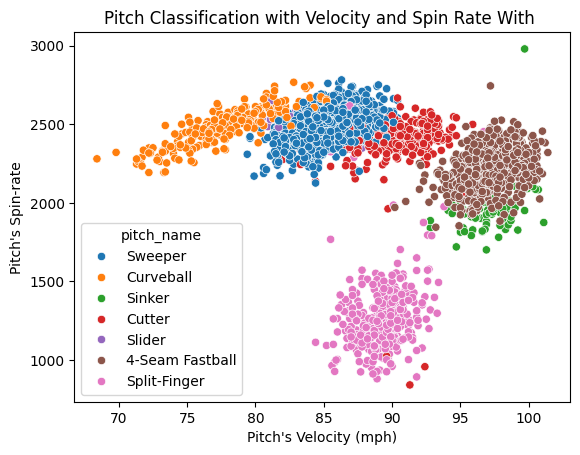

In [48]:
# visualizations
sns.scatterplot(data=pitches_train, x='release_speed', y='release_spin_rate', hue="pitch_name")
plt.title("Pitch Classification with Velocity and Spin Rate With ")
plt.xlabel("Pitch's Velocity (mph)")
plt.ylabel("Pitch's Spin-rate")
plt.show()

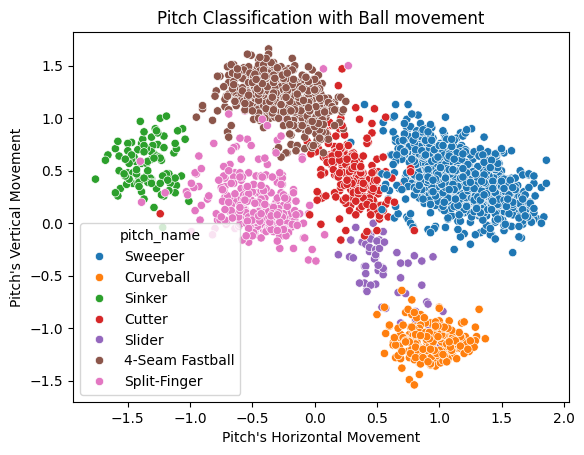

In [49]:
sns.scatterplot(data=pitches_train, x='pfx_x', y='pfx_z', hue="pitch_name")
plt.title("Pitch Classification with Ball movement")
plt.xlabel("Pitch's Horizontal Movement")
plt.ylabel("Pitch's Vertical Movement")
plt.show()

The above visualizations prove to us that our feature variables have high correlation with the pitch type. For example, we can see that a curveball is much slower than a fast ball. We can also see that a curve ball has a lot of horizontal movement while the fast ball has a lot of vertical movement.

### Models

In [50]:
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [51]:
# note numeric and categorical features
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
categorical_features = ["stand"]

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier()),
    ]
)

In [52]:
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "classifier__criterion": ["gini", "entropy"], 
    "classifier__max_depth": range(10,20),
    "classifier__min_samples_split": range(5,25),
    "classifier__min_samples_leaf": range(2,5),
}
warnings.filterwarnings("ignore")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
mod1 = grid_search.fit(X_train, y_train)

Testing accuracy using a Decision Tree Classifier.

In [53]:
# note numeric and categorical features
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
categorical_features = ["stand"]

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()),
    ]
)

In [54]:
# train models
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "classifier__n_neighbors": range(11,40,2),
    "classifier__metric": ["euclidean", "manhattan"],
}

In [55]:
warnings.filterwarnings("ignore")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
mod = grid_search.fit(X_train, y_train)

To develop a model, I first used a Pipeline to fill in any potential missing categorical or numerical data. For the first model I tried, I used a decision tree classifier. I considered using a wide range of values for the max depth, minimum samples for a split, and minimum samples for a leaf. Finally, I put it into a gridsearch and fit the model. Since I believed I could improve the accuracy, I also developed a model and tuned a k-nearest neighbors model. I considered a wide range of values of k and tested euclidean and manhattan distance. Finally I put it into a gridsearch and fit the model.

## Results

In [56]:
# report model metrics
display(f"Best parameters for Decision Tree: {mod1.best_params_}")
display(f"Best cross-validation accuracy for Decision Tree: {mod1.best_score_}")
display(f"Best parameters for KNN: {mod.best_params_}")
display(f"Best cross-validation accuracy for KNN: {mod.best_score_}")

"Best parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 12, 'preprocessor__cat__onehot__drop': 'first'}"

'Best cross-validation accuracy for Decision Tree: 0.967651638602209'

"Best parameters for KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 29, 'preprocessor__cat__onehot__drop': 'first'}"

'Best cross-validation accuracy for KNN: 0.9779257649827992'

The best Decision Tree classifier achieved an accuracy of 0.967651638602209.

Meanwhile, the best KNN model achieved an accuracy of 0.9779257649827992.

We will consider the KNN model going forward.

## Discussion

After developing a model using KNN and a decison tree classifier, the KNN perfomed much faster and with better results than the decision tree classifier. This model only took five seconds to run and the accuracy is extremly high. Meaning I'll be able to get an accurate response up in that stadium within seconds. For the most part, only 1 out of 50 Ohtani pitches will be classified incorrectly which is extremely insignificant. 

In addition, this model would also likely perform very well with other pitchers. In the future, Ohtani may start to switch up his pitches and change how he throws. This shouldn't hurt the model's accuracy enough to where I would take it out of practice. I can always continue to train it with his future pitches.

### Conclusion

Given the above, I would use this model in practice as it only took five seconds to run and the accuracy is extremly high. The model is fast and the very few incorrectly classified pitches are not significant enough to not use the model in practice. Should Ohtani start to switch up his pitches in the future, the accuracy may decrease but it can always be retained. All in all, the model that i've developed is fast and accurate enough to put into practice.

In [57]:
from joblib import dump
dump(mod, "pitch-classifier.joblib")

['pitch-classifier.joblib']